<a href="https://colab.research.google.com/github/bhargav23/AI/blob/master/Faster_Sentiment_Analysis_11-01-2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Faster Sentiment Analysis

In the previous notebook we managed to achieve a decent test accuracy of ~84% using all of the common techniques used for sentiment analysis. In this notebook, we'll implement a model that gets comparable results whilst training significantly faster and using around half of the parameters. More specifically, we'll be implementing the "FastText" model from the paper [Bag of Tricks for Efficient Text Classification](https://arxiv.org/abs/1607.01759).

## Preparing Data

One of the key concepts in the FastText paper is that they calculate the n-grams of an input sentence and append them to the end of a sentence. Here, we'll use bi-grams. Briefly, a bi-gram is a pair of words/tokens that appear consecutively within a sentence. 

For example, in the sentence "how are you ?", the bi-grams are: "how are", "are you" and "you ?".

The `generate_bigrams` function takes a sentence that has already been tokenized, calculates the bi-grams and appends them to the end of the tokenized list.

In [5]:
!pip install -q kaggle

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 92% 222M/242M [00:00<00:00, 236MB/s]
100% 242M/242M [00:01<00:00, 237MB/s]


In [8]:
!unzip amazon-fine-food-reviews.zip -d data

Archive:  amazon-fine-food-reviews.zip
  inflating: data/Reviews.csv        
  inflating: data/database.sqlite    
  inflating: data/hashes.txt         


In [9]:
DATA_PATH = 'data/Reviews.csv'

In [10]:
import pandas as pd
import numpy as np
import torch

In [11]:
odf = pd.read_csv('data/Reviews.csv')

In [12]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

In [13]:
TEXT = pd.Series(X,name="Text")
train_df = pd.concat([TEXT, y], axis=1)

In [14]:
train_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [15]:
train_df.dtypes

Text     object
Score     int64
dtype: object

In [16]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 420651
Number of testing examples: 105163


In [18]:
import random
SEED = 1234
train_data, valid_data = train_test_split(train_data,random_state = random.seed(SEED))

In [19]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 315488
Number of validation examples: 105163
Number of testing examples: 105163


In [20]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

As an example:

In [21]:
generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'film is', 'This film', 'is terrible']

TorchText `Field`s have a `preprocessing` argument. A function passed here will be applied to a sentence after it has been tokenized (transformed from a string into a list of tokens), but before it has been numericalized (transformed from a list of tokens to a list of indexes). This is where we'll pass our `generate_bigrams` function.

As we aren't using an RNN we can't use packed padded sequences, thus we do not need to set `include_lengths = True`.

In [22]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', preprocessing = generate_bigrams)
SCORE = data.LabelField(dtype = torch.float)

In [23]:
fields = {'Text': ('t', TEXT), 'Score': ('s', SCORE)}

In [24]:
train_data.to_csv('train.csv')
valid_data.to_csv('valid.csv')
test_data.to_csv('test.csv')

In [25]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = False
)

In [26]:
print(vars(train_data[0]))

{'t': ['I', 'really', 'like', 'this', 'banana', 'bread', 'bar', '.', 'It', "'s", 'very', 'tasty', 'and', 'refilling', '.', 'The', 'texture', 'of', 'Lalabar', 'is', 'different', 'from', 'all', 'other', 'bars', 'I', 'had', 'before', '.', 'It', "'s", 'soft', ',', 'full', 'of', 'fruits', ',', 'dates', 'and', 'almonds', '.', 'I', 'would', 'like', 'to', 'purchase', 'again', 'this', 'product', '!', 'different from', '. It', 'product !', 'like this', 'really like', 'I would', 'bar .', 'bars I', 'would like', 'again this', 'and refilling', 'I had', 'texture of', 'dates and', 'fruits ,', 'bread bar', 'had before', 'The texture', 'this product', 'I really', 'and almonds', 'of Lalabar', 'full of', "'s very", '. The', 'from all', "'s soft", ', full', 'like to', 'banana bread', 'before .', 'this banana', 'other bars', ', dates', 'purchase again', 'is different', 'Lalabar is', "It 's", '. I', 'all other', 'refilling .', 'very tasty', 'to purchase', 'of fruits', 'tasty and', 'almonds .', 'soft ,'], 's


As before, we load the IMDb dataset and create the splits.

In [27]:
#import random

#train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

#train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Build the vocab and load the pre-trained word embeddings.

In [28]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

SCORE.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:29, 2.22MB/s]                           
 99%|█████████▉| 397524/400000 [00:15<00:00, 26639.89it/s]

And create the iterators.

In [29]:
"""
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)
"""
BATCH_SIZE = 64
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.t), #sort by s attribute (quote)
    batch_size=BATCH_SIZE,
    device=device)

## Build the Model

This model has far fewer parameters than the previous model as it only has 2 layers that have any parameters, the embedding layer and the linear layer. There is no RNN component in sight!

Instead, it first calculates the word embedding for each word using the `Embedding` layer (blue), then calculates the average of all of the word embeddings (pink) and feeds this through the `Linear` layer (silver), and that's it!

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment8.png?raw=1)

We implement the averaging with the `avg_pool2d` (average pool 2-dimensions) function. Initially, you may think using a 2-dimensional pooling seems strange, surely our sentences are 1-dimensional, not 2-dimensional? However, you can think of the word embeddings as a 2-dimensional grid, where the words are along one axis and the dimensions of the word embeddings are along the other. The image below is an example sentence after being converted into 5-dimensional word embeddings, with the words along the vertical axis and the embeddings along the horizontal axis. Each element in this [4x5] tensor is represented by a green block.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment9.png?raw=1)

The `avg_pool2d` uses a filter of size `embedded.shape[1]` (i.e. the length of the sentence) by 1. This is shown in pink in the image below.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment10.png?raw=1)

We calculate the average value of all elements covered by the filter, then the filter then slides to the right, calculating the average over the next column of embedding values for each word in the sentence. 

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment11.png?raw=1)

Each filter position gives us a single value, the average of all covered elements. After the filter has covered all embedding dimensions we get a [1x5] tensor. This tensor is then passed through the linear layer to produce our prediction.

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

As previously, we'll create an instance of our `FastText` class.

In [31]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

Looking at the number of parameters in our model, we see we have about the same as the standard RNN from the first notebook and half the parameters of the previous model.

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,500,301 trainable parameters


And copy the pre-trained vectors to our embedding layer.

In [33]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0633,  0.8515, -0.2496,  ...,  2.8214, -0.4939, -1.9222],
        [-0.5461, -1.1701,  0.1877,  ..., -0.7691, -0.7788, -1.4971],
        [ 0.3156, -0.0757,  0.5920,  ..., -0.3174, -0.6237,  0.4088]])

Not forgetting to zero the initial weights of our unknown and padding tokens.

In [34]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

Training the model is the exact same as last time.

We initialize our optimizer...

In [35]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

We define the criterion and place the model and criterion on the GPU (if available)...

In [36]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [37]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

**Note**: we are no longer using dropout so we do not need to use `model.train()`, but as mentioned in the 1st notebook, it is good practice to use it.

In [38]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.t).squeeze(1)
        
        loss = criterion(predictions, batch.s)
        
        acc = binary_accuracy(predictions, batch.s)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note**: again, we leave `model.eval()` even though we do not use dropout.

In [39]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.t).squeeze(1)
            
            loss = criterion(predictions, batch.s)
            
            acc = binary_accuracy(predictions, batch.s)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

As before, we'll implement a useful function to tell us how long an epoch takes.

In [40]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

In [41]:
trainLosses = []
testLosses = []
trainAcc = []
testAcc = []
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    trainLosses.append(train_loss*100)
    testLosses.append(valid_loss*100)
    trainAcc.append(train_acc*100)
    testAcc.append(valid_acc*100)

 99%|█████████▉| 397524/400000 [00:29<00:00, 26639.89it/s]

Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 0.301 | Train Acc: 88.37%
	 Val. Loss: 0.365 |  Val. Acc: 93.28%
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.165 | Train Acc: 93.67%
	 Val. Loss: 0.398 |  Val. Acc: 94.34%
Epoch: 03 | Epoch Time: 1m 18s
	Train Loss: 0.138 | Train Acc: 94.95%
	 Val. Loss: 0.413 |  Val. Acc: 94.81%
Epoch: 04 | Epoch Time: 1m 18s
	Train Loss: 0.124 | Train Acc: 95.64%
	 Val. Loss: 0.428 |  Val. Acc: 95.03%
Epoch: 05 | Epoch Time: 1m 18s
	Train Loss: 0.114 | Train Acc: 96.06%
	 Val. Loss: 0.447 |  Val. Acc: 95.18%


Text(0.5, 1.0, 'Loss')

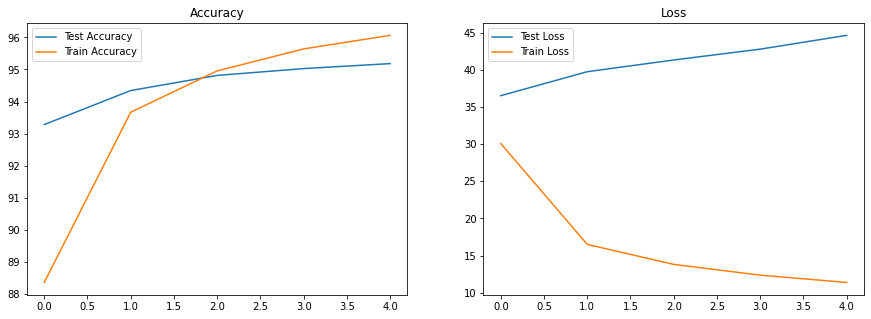

In [46]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(testAcc)
axs[0].plot(trainAcc)
axs[0].legend(['Test Accuracy', 'Train Accuracy'], loc='upper left')
axs[0].set_title("Accuracy")
axs[1].plot(testLosses)
axs[1].plot(trainLosses)
axs[1].legend(['Test Loss', 'Train Loss'], loc='upper left')
axs[1].set_title("Loss")

...and get the test accuracy!

The results are comparable to the results in the last notebook, but training takes considerably less time!

In [42]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.368 | Test Acc: 93.37%


## User Input

And as before, we can test on any input the user provides making sure to generate bigrams from our tokenized sentence.

In [43]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

An example negative review...

In [44]:
predict_sentiment(model, "This film is terrible")

1.0

An example positive review...

In [45]:
predict_sentiment(model, "This film is great")

0.0

## Next Steps

In the next notebook we'll use convolutional neural networks (CNNs) to perform sentiment analysis.